In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "/content/drive/MyDrive/data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
ALL_POSITIONS = ["dom_hand", "nondom_hand"]

TRAIN_POSITIONS = ["dom_hand"]
TEST_POSITIONS = ["nondom_hand"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2

WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 10

In [14]:
def load_selected_csvs(base_dir, positions):
    dfs = []

    for activity in SELECTED_ACTIVITIES:
        for position in positions:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(
                    os.path.basename(csv_path)
                )[0]
                dfs.append(df)

    print(
        f"Loaded {len(dfs)} recordings | "
        f"Activities={SELECTED_ACTIVITIES} | "
        f"Positions={positions}"
    )
    return dfs

In [15]:
def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)


def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]


def build_dataset_cnn(dfs, feature_cols):
    X, y, groups, positions = [], [], [], []

    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue

        for w in sliding_windows(df):
            window_data = w[feature_cols].values
            X.append(window_data)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
            positions.append(w["phone_position"].iloc[0])

    return (
        np.array(X),
        np.array(y),
        np.array(groups),
        np.array(positions)
    )

In [16]:
class ActivityDataset(Dataset):
    def __init__(self, X, y, scaler=None):
        if scaler is not None:
            orig_shape = X.shape
            X_flat = X.reshape(-1, X.shape[-1])
            X_flat = scaler.transform(X_flat)
            X = X_flat.reshape(orig_shape)
        self.X = torch.FloatTensor(X).transpose(1, 2)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [23]:
class CNN1D(nn.Module):
    def __init__(self, num_features, num_classes):
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(num_features, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.3)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(256, 128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

In [18]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    return avg_loss, accuracy, all_preds, all_labels

In [25]:
class CNN1D(nn.Module):
    def __init__(self, num_features, num_classes):
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(num_features, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.3)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(256, 128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu(self.bn3(self.conv3(x)))))

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = self.dropout4(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [26]:
def cross_position_evaluation(X_train, y_train, groups_train,
                               X_test, y_test,
                               title, num_features):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    num_classes = len(le.classes_)

    print(f"Training on positions with 5-fold CV")

    outer_cv = GroupKFold(n_splits=5)

    fold_val_metrics = []
    fold_models = []
    fold_scalers = []

    for fold, (train_idx, val_idx) in enumerate(
        outer_cv.split(X_train, y_train_encoded, groups_train), 1
    ):
        print(f"Fold {fold}/5")

        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

        scaler = StandardScaler()
        X_tr_flat = X_tr.reshape(-1, X_tr.shape[-1])
        scaler.fit(X_tr_flat)

        train_dataset = ActivityDataset(X_tr, y_tr, scaler)
        val_dataset = ActivityDataset(X_val, y_val, scaler)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model = CNN1D(num_features, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        best_val_acc = 0
        patience_counter = 0
        best_model_state = None

        for epoch in range(EPOCHS):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, _, _ = evaluate_epoch(model, val_loader, criterion, device)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS} - "
                      f"Train Loss: {train_loss:.4f}, "
                      f"Val Loss: {val_loss:.4f}, "
                      f"Val Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_state = model.state_dict().copy()


        model.load_state_dict(best_model_state)

        _, val_acc, val_preds, val_labels = evaluate_epoch(
            model, val_loader, criterion, device
        )

        fold_val_metrics.append({
            'accuracy': val_acc,
            'f1': f1_score(val_labels, val_preds, average='macro')
        })

        fold_models.append(model.state_dict().copy())
        fold_scalers.append(scaler)

        print(f"Fold {fold} Best Val Accuracy: {best_val_acc:.4f}")

    avg_val_acc = np.mean([m['accuracy'] for m in fold_val_metrics])
    avg_val_f1 = np.mean([m['f1'] for m in fold_val_metrics])
    print(f"Average 5-Fold Validation Accuracy: {avg_val_acc:.4f}")
    print(f"Average 5-Fold Validation F1: {avg_val_f1:.4f}")
    print(f"Training final model on ALL training positions")
    print(f"Testing on held-out test positions")

    final_scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    final_scaler.fit(X_train_flat)

    train_dataset = ActivityDataset(X_train, y_train_encoded, final_scaler)
    test_dataset = ActivityDataset(X_test, y_test_encoded, final_scaler)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    final_model = CNN1D(num_features, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(final_model.parameters(), lr=LEARNING_RATE)

    best_train_loss = float('inf')
    best_model_state = None

    for epoch in range(EPOCHS):
        train_loss = train_epoch(final_model, train_loader, criterion, optimizer, device)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}")

        if train_loss < best_train_loss:
            best_train_loss = train_loss
            best_model_state = final_model.state_dict().copy()

    final_model.load_state_dict(best_model_state)
    test_loss, test_acc, test_preds, test_labels = evaluate_epoch(
        final_model, test_loader, criterion, device
    )

    y_test_labels = le.inverse_transform(test_labels)
    y_pred_labels = le.inverse_transform(test_preds)

    print(f"=== {title} ===")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test_labels, y_pred_labels, digits=4))

    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=SELECTED_ACTIVITIES)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=SELECTED_ACTIVITIES,
        yticklabels=SELECTED_ACTIVITIES,
        cmap="Blues"
    )
    plt.title(f"{title}\n(Trained on: {TRAIN_POSITIONS})\n(Tested on: {TEST_POSITIONS})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    print("Per-Position Performance on Test Set:")
    positions_test = np.array([TEST_POSITIONS[i % len(TEST_POSITIONS)]
                               for i in range(len(y_test_labels))])
    for pos in TEST_POSITIONS:
        mask = positions_test == pos
        if mask.sum() > 0:
            pos_acc = np.mean(y_test_labels[mask] == y_pred_labels[mask])
            pos_f1 = f1_score(y_test_labels[mask], y_pred_labels[mask], average='macro')
            print(f"{pos:15s} - Accuracy: {pos_acc:.4f}, F1: {pos_f1:.4f}")

    return {
        "test_precision": precision_score(y_test_labels, y_pred_labels, average="macro"),
        "test_recall": recall_score(y_test_labels, y_pred_labels, average="macro"),
        "test_f1": f1_score(y_test_labels, y_pred_labels, average="macro"),
        "test_accuracy": test_acc,
        "avg_val_accuracy": avg_val_acc,
        "avg_val_f1": avg_val_f1
    }

Loaded 20 recordings | Activities=['sit', 'walk', 'run', 'stairs'] | Positions=['dom_hand']
Loaded 20 recordings | Activities=['sit', 'walk', 'run', 'stairs'] | Positions=['nondom_hand']
Using device: cuda
Training on positions with 5-fold CV
Fold 1/5
Epoch 10/50 - Train Loss: 0.0144, Val Loss: 0.1185, Val Acc: 0.9403
Epoch 20/50 - Train Loss: 0.0031, Val Loss: 0.1712, Val Acc: 0.9104
Epoch 30/50 - Train Loss: 0.0022, Val Loss: 0.0448, Val Acc: 0.9801
Epoch 40/50 - Train Loss: 0.0132, Val Loss: 0.0318, Val Acc: 0.9801
Epoch 50/50 - Train Loss: 0.0008, Val Loss: 0.1620, Val Acc: 0.9403
Fold 1 Best Val Accuracy: 0.9900
Fold 2/5
Epoch 10/50 - Train Loss: 0.0177, Val Loss: 0.0873, Val Acc: 0.9652
Epoch 20/50 - Train Loss: 0.0013, Val Loss: 0.1348, Val Acc: 0.9502
Epoch 30/50 - Train Loss: 0.0005, Val Loss: 0.0737, Val Acc: 0.9602
Epoch 40/50 - Train Loss: 0.0276, Val Loss: 0.4508, Val Acc: 0.8408
Epoch 50/50 - Train Loss: 0.0006, Val Loss: 0.1453, Val Acc: 0.9602
Fold 2 Best Val Accuracy: 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


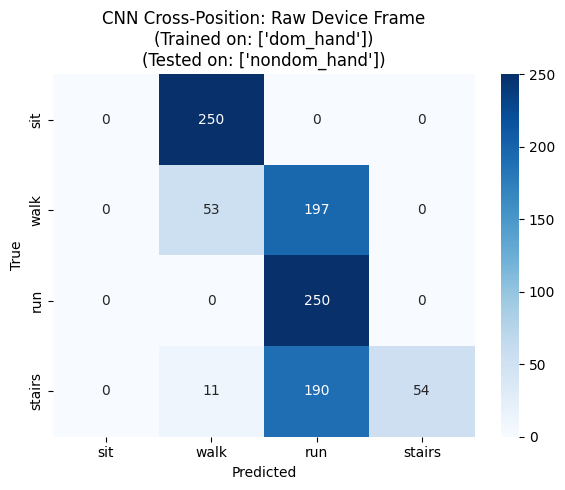

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Per-Position Performance on Test Set:
nondom_hand     - Accuracy: 0.3552, F1: 0.2753
Using device: cuda
Training on positions with 5-fold CV
Fold 1/5
Epoch 10/50 - Train Loss: 0.0161, Val Loss: 0.2025, Val Acc: 0.8657
Epoch 20/50 - Train Loss: 0.0079, Val Loss: 0.0827, Val Acc: 0.9453
Epoch 30/50 - Train Loss: 0.0256, Val Loss: 0.0202, Val Acc: 1.0000
Epoch 40/50 - Train Loss: 0.0177, Val Loss: 0.0592, Val Acc: 0.9701
Epoch 50/50 - Train Loss: 0.0051, Val Loss: 0.0468, Val Acc: 0.9701
Fold 1 Best Val Accuracy: 1.0000
Fold 2/5
Epoch 10/50 - Train Loss: 0.0282, Val Loss: 0.4520, Val Acc: 0.7811
Epoch 20/50 - Train Loss: 0.0151, Val Loss: 0.1652, Val Acc: 0.9154
Epoch 30/50 - Train Loss: 0.0100, Val Loss: 0.1190, Val Acc: 0.9303
Epoch 40/50 - Train Loss: 0.0026, Val Loss: 0.0809, Val Acc: 0.9552
Epoch 50/50 - Train Loss: 0.0007, Val Loss: 0.1011, Val Acc: 0.9403
Fold 2 Best Val Accuracy: 0.9900
Fold 3/5
Epoch 10/50 - Train Loss: 0.0383, Val Loss: 0.1827, Val Acc: 0.8905
Epoch 20/50 - Trai

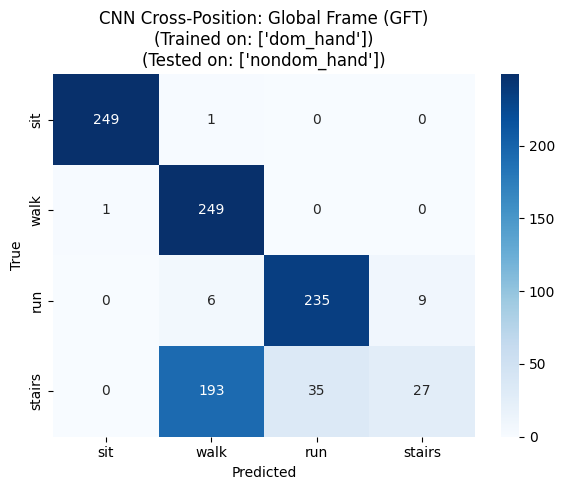

Per-Position Performance on Test Set:
nondom_hand     - Accuracy: 0.7562, F1: 0.6995
Summary

Training positions: ['dom_hand']
Testing positions:  ['nondom_hand']

Raw Device Frame:
  Validation (5-fold avg): Acc=0.9642, F1=0.9641
  Test Set:                Acc=0.3552, F1=0.2753

Global Frame (GFT):
  Validation (5-fold avg): Acc=0.9224, F1=0.9210
  Test Set:                Acc=0.7562, F1=0.6995


In [27]:
if __name__ == "__main__":
    train_recordings = load_selected_csvs(DATA_DIR, TRAIN_POSITIONS)
    test_recordings = load_selected_csvs(DATA_DIR, TEST_POSITIONS)
    X_train_raw, y_train_raw, g_train_raw, _ = build_dataset_cnn(
        train_recordings, RAW_FEATURES
    )
    X_test_raw, y_test_raw, _, _ = build_dataset_cnn(
        test_recordings, RAW_FEATURES
    )
    raw_metrics = cross_position_evaluation(
        X_train_raw, y_train_raw, g_train_raw,
        X_test_raw, y_test_raw,
        "CNN Cross-Position: Raw Device Frame",
        num_features=len(RAW_FEATURES)
    )

    X_train_gft, y_train_gft, g_train_gft, _ = build_dataset_cnn(
        train_recordings, GFT_FEATURES
    )
    X_test_gft, y_test_gft, _, _ = build_dataset_cnn(
        test_recordings, GFT_FEATURES
    )

    gft_metrics = cross_position_evaluation(
        X_train_gft, y_train_gft, g_train_gft,
        X_test_gft, y_test_gft,
        "CNN Cross-Position: Global Frame (GFT)",
        num_features=len(GFT_FEATURES)
    )

    print("Summary")
    print(f"\nTraining positions: {TRAIN_POSITIONS}")
    print(f"Testing positions:  {TEST_POSITIONS}\n")
    print("Raw Device Frame:")
    print(f"  Validation (5-fold avg): Acc={raw_metrics['avg_val_accuracy']:.4f}, F1={raw_metrics['avg_val_f1']:.4f}")
    print(f"  Test Set:                Acc={raw_metrics['test_accuracy']:.4f}, F1={raw_metrics['test_f1']:.4f}")
    print("\nGlobal Frame (GFT):")
    print(f"  Validation (5-fold avg): Acc={gft_metrics['avg_val_accuracy']:.4f}, F1={gft_metrics['avg_val_f1']:.4f}")
    print(f"  Test Set:                Acc={gft_metrics['test_accuracy']:.4f}, F1={gft_metrics['test_f1']:.4f}")